In [55]:
import sys
sys.path.append("../Face_detection")


import pandas as pd
import tensorflow as tf
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt


from PIL import Image
from typing import List
from matplotlib.gridspec import GridSpec
from keras.preprocessing.image import img_to_array, load_img
from keras.models import load_model
from face_detection import detect_face, detect_face_mediapipe
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [56]:
df = pd.read_csv('evaluation_dataset.csv', sep=';')

print(df)

     Image  Gender Beard Glasses Haircolor  Nation
0   01.jpg    Male   Yes      No     Brown   White
1   02.jpg    Male   Yes      No     Brown   White
2   03.jpg  Female    No     Yes     Black  Indian
3   04.jpg    Male   Yes      No     Black   Black
4   05.jpg    Male   Yes      No      Gray   White
5   06.jpg    Male    No      No     Black   Black
6   07.jpg  Female    No      No     Black  Indian
7   08.jpg  Female    No      No     Black   Black
8   09.jpg    Male   Yes      No      Gray   Black
9   10.jpg  Female    No     Yes      Gray   White
10  11.jpg    Male   Yes      No     Brown   White
11  12.jpg    Male    No      No     Black   White
12  13.jpg  Female    No      No     Black   White
13  14.jpg    Male   Yes      No     Black   White


# Plot now the images with their actual value and predicted value

In [57]:
images_dir = "Images/"

# Maybe we can parallelize this to make it faster
gender_model_without_pipeline = tf.keras.models.load_model(os.path.join("../Models/Without_DA_Pipeline/", "Gender_classification"))
beard_model_without_pipeline = tf.keras.models.load_model(os.path.join("../Models/Without_DA_Pipeline/", "Beard_classification"))
glasses_model_without_pipeline = tf.keras.models.load_model(os.path.join("../Models/Without_DA_Pipeline/", "Glasses_classification"))
haircolor_model_without_pipeline = tf.keras.models.load_model(os.path.join("../Models/Without_DA_Pipeline/", "Haircolor_classification"))
nation_model_without_pipeline = tf.keras.models.load_model(os.path.join("../Models/Without_DA_Pipeline/", "Nation_classification"))

gender_model_with_pipeline = tf.keras.models.load_model(os.path.join("../Models/With_DA_Pipeline/", "Gender_classification"))
beard_model_with_pipeline = tf.keras.models.load_model(os.path.join("../Models/With_DA_Pipeline/", "Beard_classification"))
glasses_model_with_pipeline = tf.keras.models.load_model(os.path.join("../Models/With_DA_Pipeline/", "Glasses_classification"))
haircolor_model_with_pipeline = tf.keras.models.load_model(os.path.join("../Models/With_DA_Pipeline/", "Haircolor_classification"))
nation_model_with_pipeline = tf.keras.models.load_model(os.path.join("../Models/With_DA_Pipeline/", "Nation_classification"))

In [58]:
# Class names for categorical prediction
gender_class_names = ['Female', 'Male']
beard_class_names = ['Yes', 'No']
glasses_class_names = ['Yes', 'No']
haircolor_class_names = ['Black', 'Blond', 'Brown', 'Gray']
nation_class_names = ['Asian', 'Black', 'Indian', 'Other', 'White']

In [59]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)

    img_array = img_to_array(img)
    img_array = img_array / 255.0 

    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array


def predict_and_display_images(models, df, face_detection: bool):
    if not os.path.exists(images_dir):
        raise FileNotFoundError(f"Directory {images_dir} doesn't exist!")
        
    predictions = []
    displayed = 0

    for index, row in df.iterrows():
        image_name = row['Image']
        
        #if image_name[:-4] < "11":
        #    continue
        
        image_path = os.path.join(images_dir, image_name)

        if not os.path.exists(image_path):
            print(f"Error: Image {image_path} not found!")
            continue

        if face_detection:
            face = detect_face_mediapipe(image_path)
            if face is None:
                print(f"No face detected in image {image_name}, skipping.")
                continue
            face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(face_rgb)
            pil_img = pil_img.resize((224, 224))
            img_array = img_to_array(pil_img)
            img_array = img_array / 255.0
            img_array = np.expand_dims(img_array, axis=0)
        else:
            img_array = preprocess_image(image_path)

        gender_pred = models[0].predict(img_array, verbose=0)
        beard_pred = models[1].predict(img_array, verbose=0)
        glasses_pred = models[2].predict(img_array, verbose=0)
        haircolor_pred = models[3].predict(img_array, verbose=0)
        nation_pred = models[4].predict(img_array, verbose=0)

        gender_predicted_labels = (gender_pred > 0.5).astype(int).flatten()
        gender_label = gender_class_names[gender_predicted_labels[0]]
        
        beard_predicted_labels = (beard_pred > 0.5).astype(int).flatten()
        beard_label = beard_class_names[beard_predicted_labels[0]]
        
        glasses_predicted_labels = (glasses_pred > 0.5).astype(int).flatten()
        glasses_label = glasses_class_names[glasses_predicted_labels[0]]
        
        haircolor_label_index = np.argmax(haircolor_pred, axis=1)[0]
        haircolor_label = haircolor_class_names[haircolor_label_index]
        
        nation_label_index = np.argmax(nation_pred, axis=1)[0]
        nation_label = nation_class_names[nation_label_index]
        
        
        predictions.append({
            "Image": image_name,
            "Gender_Pred": gender_label,
            "Beard_Pred": beard_label,
            "Glasses_Pred": glasses_label,
            "Haircolor_Pred": haircolor_label,
            "Nation_Pred": nation_label
        })

        gt_gender = row['Gender']
        gt_beard = row['Beard']
        gt_glasses = row['Glasses']
        gt_haircolor = row['Haircolor']
        gt_nation = row['Nation']

        """
        fig = plt.figure(figsize=(11, 4))
        gs = GridSpec(1, 2, width_ratios=[1, 1.5])

        ax_img = fig.add_subplot(gs[0])
        if face_detection and face is not None:
            ax_img.imshow(face_rgb)
        else:
            ax_img.imshow(load_img(image_path))
        ax_img.axis('off')
        ax_img.set_title(f"Image: {image_name[:-4]}", fontsize=13, pad=10)

        lines = [
            f"Gender:     {gender_label:<8}  (GT: {gt_gender})",
            f"Beard:      {beard_label:<8}  (GT: {gt_beard})",
            f"Glasses:    {glasses_label:<8}  (GT: {gt_glasses})",
            f"Haircolor:  {haircolor_label:<8}  (GT: {gt_haircolor})",
            f"Nation:     {nation_label:<8}  (GT: {gt_nation})"
        ]
        text = "\n".join(lines)

        ax_text = fig.add_subplot(gs[1])
        ax_text.axis('off')
        ax_text.text(
            0.0, 0.5, text,
            fontsize=13,
            verticalalignment='center',
            horizontalalignment='left',
            family='monospace',
            transform=ax_text.transAxes
        )

        plt.tight_layout()
        plt.show()

        displayed += 1
        """
        
    pred_df = pd.DataFrame(predictions)
    df_with_preds = pd.merge(df, pred_df, on="Image", how="inner")

    return df_with_preds

# Prediction of the Images without using the Data Augmentation Pipeline

In [60]:
df_preds_without_pipeline_without_face_detection = predict_and_display_images(
    models=[gender_model_without_pipeline, beard_model_without_pipeline, glasses_model_without_pipeline, haircolor_model_without_pipeline, nation_model_without_pipeline],
    df=df,
    face_detection=False
)

df_preds_without_pipeline_with_face_detection = predict_and_display_images(
    models=[gender_model_without_pipeline, beard_model_without_pipeline, glasses_model_without_pipeline, haircolor_model_without_pipeline, nation_model_without_pipeline],
    df=df,
    face_detection=True
)

W0000 00:00:1752399743.189572   36089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752399743.851044   36276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752399744.694191   36470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752399745.418946   36657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752399746.015886   36844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752399746.614731   37031 inference_feedback_manager.cc:114] Feedback manager 

# Prediction of the Images with using the Data Augmentation Pipeline

In [61]:
df_preds_with_pipeline_without_face_detection = predict_and_display_images(
    models=[gender_model_with_pipeline, beard_model_with_pipeline, glasses_model_with_pipeline, haircolor_model_with_pipeline, nation_model_with_pipeline],
    df=df,
    face_detection=False
)

df_preds_with_pipeline_with_face_detection = predict_and_display_images(
    models=[gender_model_with_pipeline, beard_model_with_pipeline, glasses_model_with_pipeline, haircolor_model_with_pipeline, nation_model_with_pipeline],
    df=df,
    face_detection=True
)

W0000 00:00:1752399763.721957   41262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752399764.380529   41449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752399765.241681   41643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752399765.982510   41830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752399766.611790   42020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752399767.264971   42208 inference_feedback_manager.cc:114] Feedback manager 

In [62]:
def plot_confusion_matrix(df_preds_one, df_preds_one_title,  df_preds_two, df_preds_two_title) -> None:
    properties = ["Gender", "Beard", "Glasses", "Haircolor", "Nation"]
    labels_dict = {
        "Gender": ['Female', 'Male'],
        "Beard": ["Yes", "No"],
        "Glasses": ["Yes", "No"],
        "Haircolor": ["Black", "Blond", "Brown", "Gray"],
        "Nation": ["Asian", "Black", "Indian", "Other", "White"]
    }

    for prop in properties:
        print(f"{prop}:")

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        cm_without = confusion_matrix(
            df_preds_one[prop], 
            df_preds_one[f"{prop}_Pred"], 
            labels=labels_dict[prop]
        )
        disp_without = ConfusionMatrixDisplay(confusion_matrix=cm_without, display_labels=labels_dict[prop])
        disp_without.plot(ax=axes[0])
        axes[0].set_title(f"{prop} - {df_preds_one_title}")

        cm_with = confusion_matrix(
            df_preds_two[prop], 
            df_preds_two[f"{prop}_Pred"], 
            labels=labels_dict[prop]
        )
        disp_with = ConfusionMatrixDisplay(confusion_matrix=cm_with, display_labels=labels_dict[prop])
        disp_with.plot(ax=axes[1])
        axes[1].set_title(f"{prop} - {df_preds_two_title}")

        plt.tight_layout()
        plt.show()

Gender:


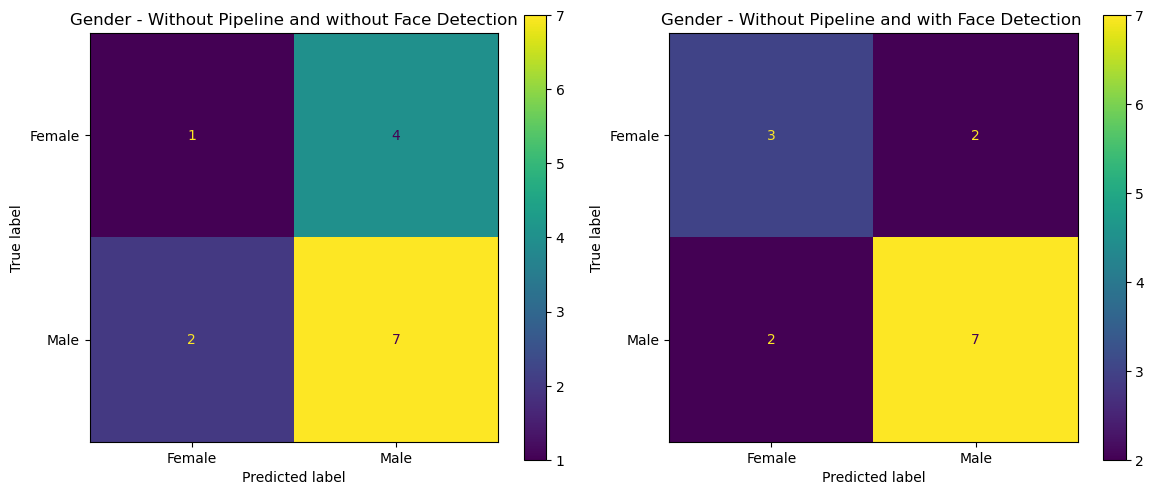

Beard:


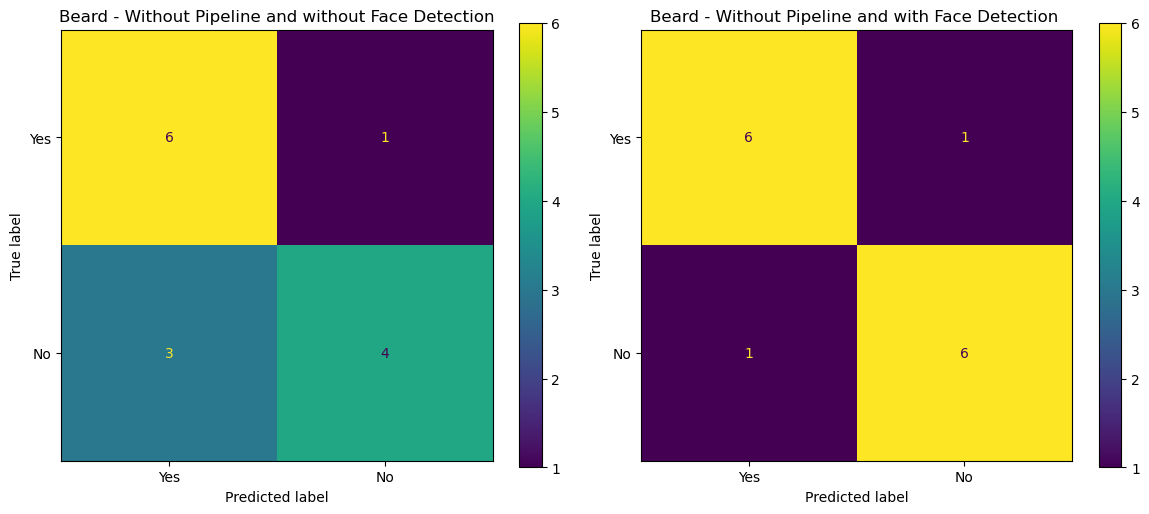

Glasses:


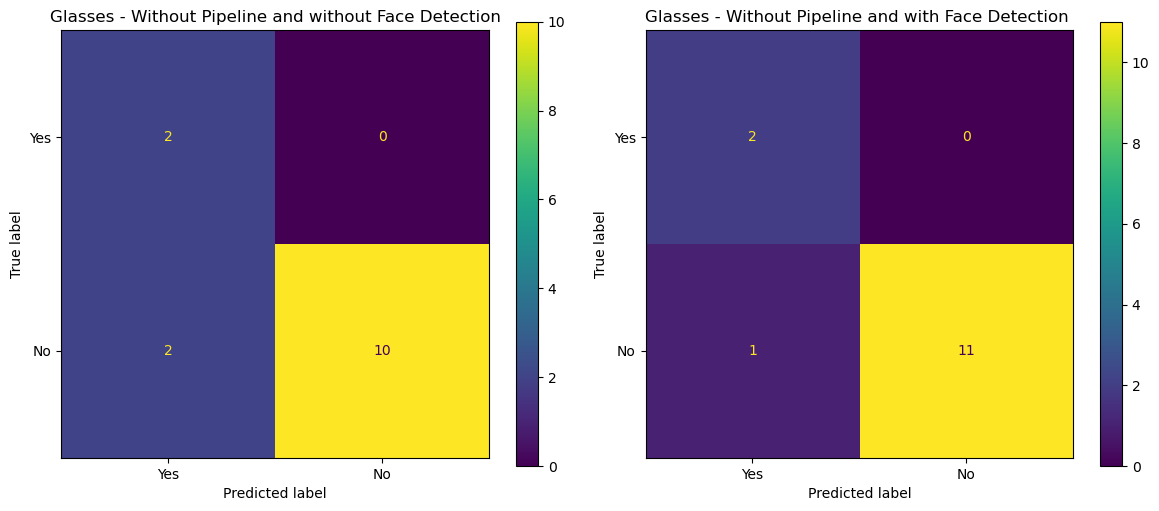

Haircolor:


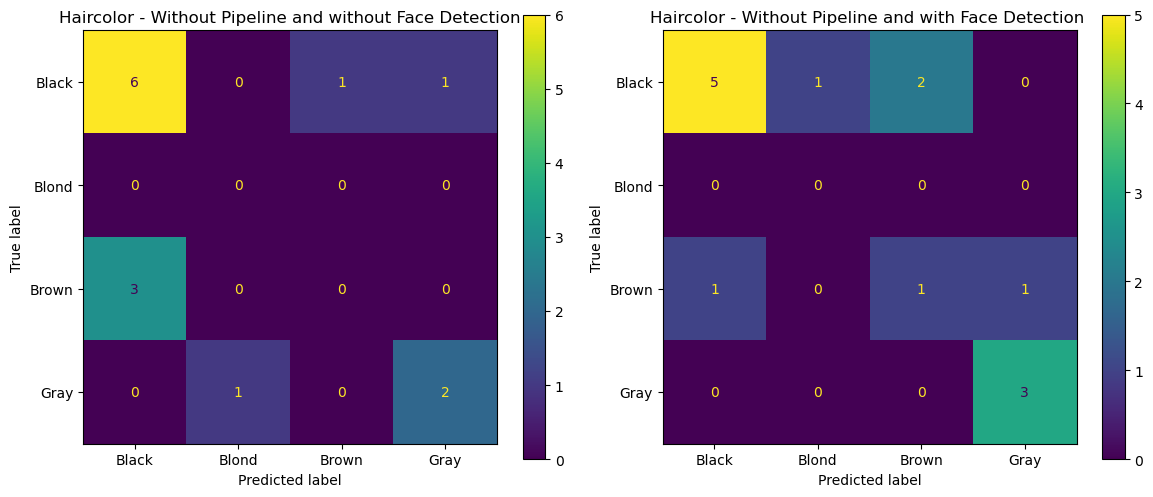

Nation:


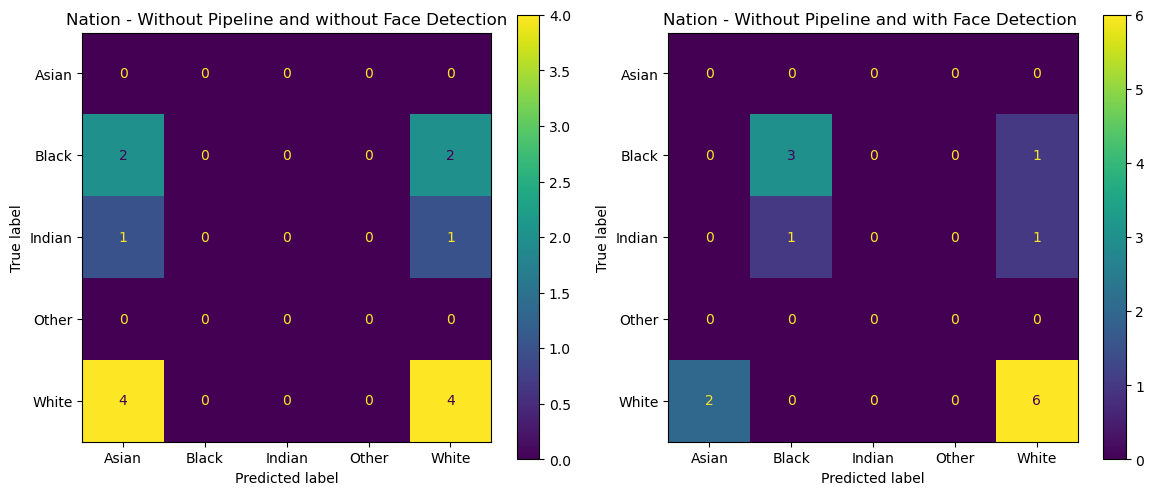

In [63]:
plot_confusion_matrix(df_preds_one=df_preds_without_pipeline_without_face_detection, df_preds_one_title="Without Pipeline and without Face Detection", df_preds_two=df_preds_without_pipeline_with_face_detection, df_preds_two_title="Without Pipeline and with Face Detection ")

Gender:


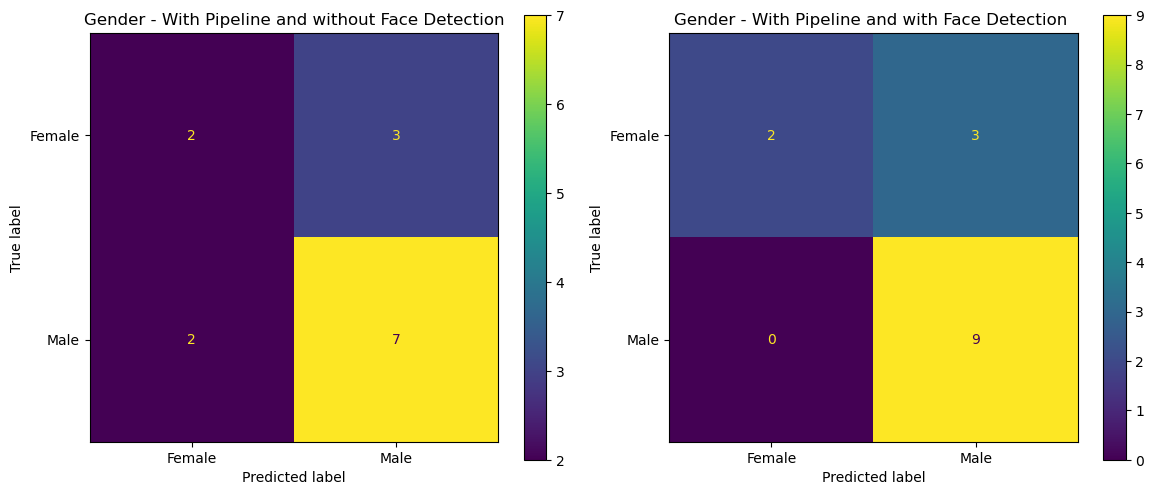

Beard:


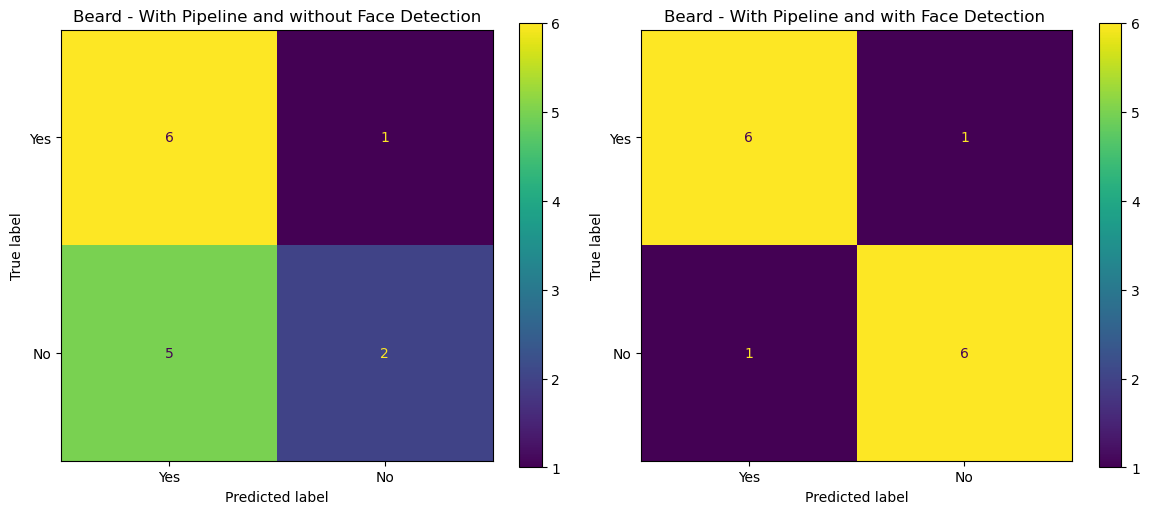

Glasses:


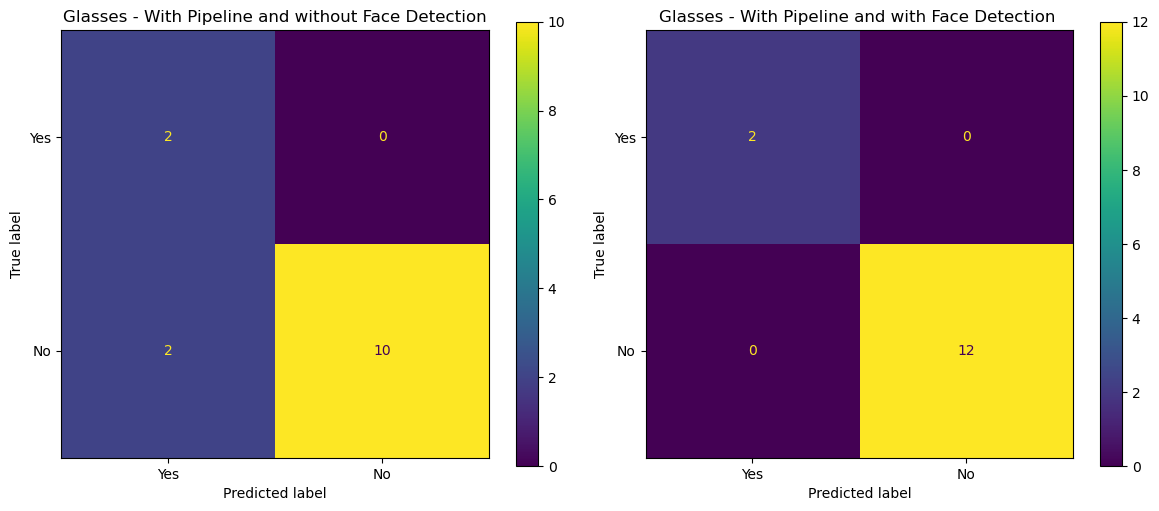

Haircolor:


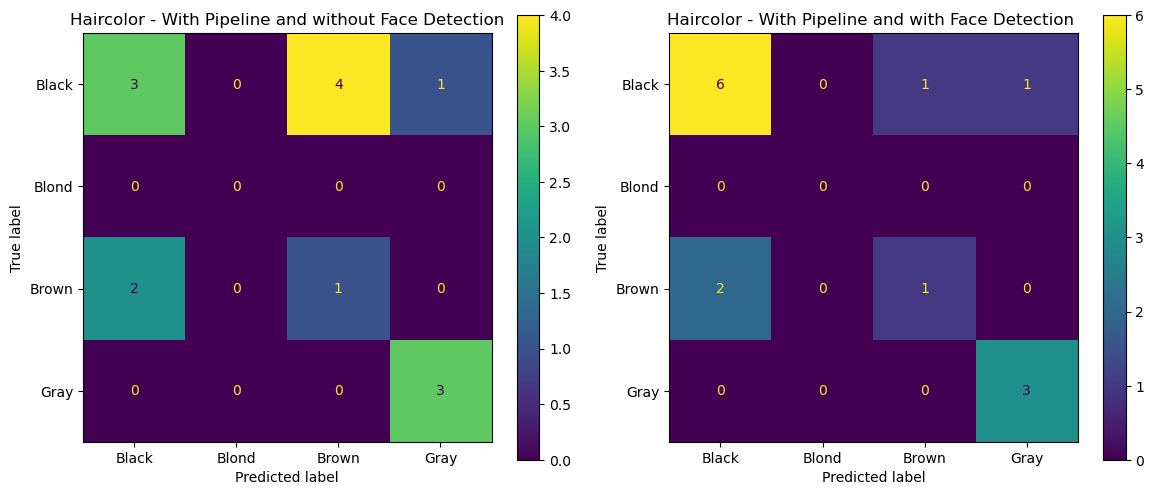

Nation:


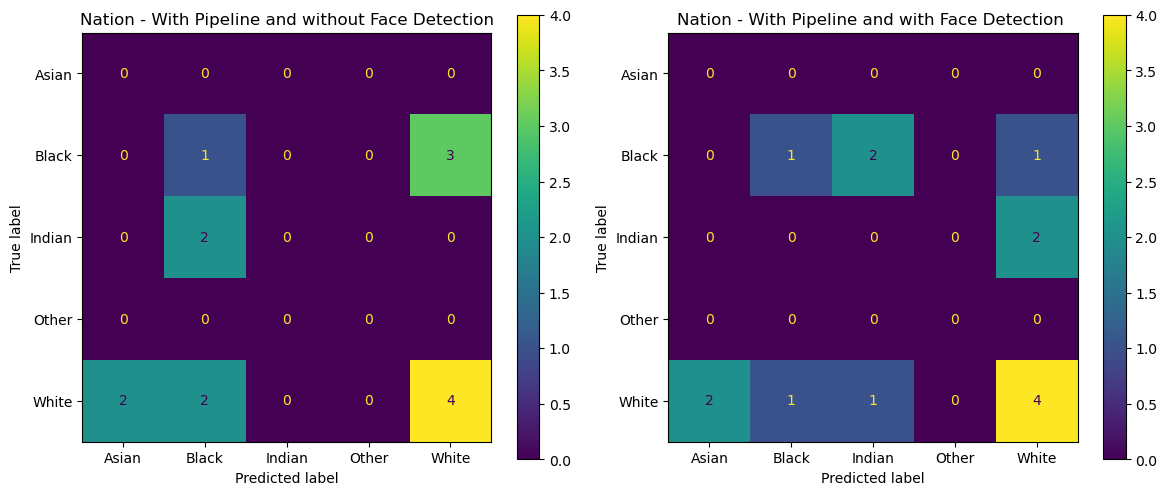

In [64]:
plot_confusion_matrix(df_preds_one=df_preds_with_pipeline_without_face_detection, df_preds_one_title="With Pipeline and without Face Detection", df_preds_two=df_preds_with_pipeline_with_face_detection, df_preds_two_title="With Pipeline and with Face Detection ")

In [65]:
def create_summary_table(df_preds) -> None:
    properties = ["Gender", "Beard", "Glasses", "Haircolor", "Nation"]
    summary_data = []

    for prop in properties:
        y_true = df_preds[prop]
        y_pred = df_preds[f"{prop}_Pred"]

        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        acc = accuracy_score(y_true, y_pred)

        f1_scores = {label: info["f1-score"] for label, info in report.items() if isinstance(info, dict)}
        best_class = max(f1_scores, key=f1_scores.get)
        worst_class = min(f1_scores, key=f1_scores.get)

        summary_data.append({
            "Attribute": prop,
            "Accuracy": round(acc, 2),
            "F1 (macro)": round(report["macro avg"]["f1-score"], 2),
            "Precision (macro)": round(report["macro avg"]["precision"], 2),
            "Recall (macro)": round(report["macro avg"]["recall"], 2),
            "Best class": best_class,
            "Worst class": worst_class
        })

        print(f"\nClassification report for {prop}:")
        print(classification_report(y_true, y_pred, zero_division=0))

    summary_df = pd.DataFrame(summary_data)
    print(summary_df)

In [66]:
create_summary_table(df_preds=df_preds_without_pipeline_without_face_detection)


Classification report for Gender:
              precision    recall  f1-score   support

      Female       0.33      0.20      0.25         5
        Male       0.64      0.78      0.70         9

    accuracy                           0.57        14
   macro avg       0.48      0.49      0.47        14
weighted avg       0.53      0.57      0.54        14


Classification report for Beard:
              precision    recall  f1-score   support

          No       0.80      0.57      0.67         7
         Yes       0.67      0.86      0.75         7

    accuracy                           0.71        14
   macro avg       0.73      0.71      0.71        14
weighted avg       0.73      0.71      0.71        14


Classification report for Glasses:
              precision    recall  f1-score   support

          No       1.00      0.83      0.91        12
         Yes       0.50      1.00      0.67         2

    accuracy                           0.86        14
   macro avg       0.75

In [67]:
create_summary_table(df_preds=df_preds_without_pipeline_with_face_detection)


Classification report for Gender:
              precision    recall  f1-score   support

      Female       0.60      0.60      0.60         5
        Male       0.78      0.78      0.78         9

    accuracy                           0.71        14
   macro avg       0.69      0.69      0.69        14
weighted avg       0.71      0.71      0.71        14


Classification report for Beard:
              precision    recall  f1-score   support

          No       0.86      0.86      0.86         7
         Yes       0.86      0.86      0.86         7

    accuracy                           0.86        14
   macro avg       0.86      0.86      0.86        14
weighted avg       0.86      0.86      0.86        14


Classification report for Glasses:
              precision    recall  f1-score   support

          No       1.00      0.92      0.96        12
         Yes       0.67      1.00      0.80         2

    accuracy                           0.93        14
   macro avg       0.83